In [20]:
# Peter Karras 2020
''' Contains the Custom Dataset creation and the CNN
    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'''

' Contains the Custom Dataset creation and the CNN\n    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'

In [21]:
""" IMPORT NEEDED MODULES """

import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import time

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets

In [50]:
# Issues with directories, use this to reset cwd and then move into desired directory 
#os.chdir("/content")
startingDir = os.getcwd()
if startingDir != r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/":
    startingDir = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/"
print(startingDir)
csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000"


C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/


In [51]:
""" CREATE CUSTOM DATASET """
# Pulls from pool of 900 thermal images
class BCIDataset2(Dataset):
    def __init__(self, csv_master_path, transform=None):
        """
        Args:
            csv_master_path (string): path to csv file with thermal image (csv's) file paths
            as first column and GPP values as the second column, rows are one set of
            correlating data points
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file 
        #self.data_info = pd.read_csv(csv_master_path, header=None)
        self.data_info = pd.read_csv(csv_master_path)
        # First column contains thermal image (csv's) file paths
        self.thermal_path_arr = np.asarray(self.data_info.iloc[:,0])
        # Second column is the GPP values for the images from first column
        self.GPP_arr = np.asarray(self.data_info.iloc[:,1])        
        self.transform = transforms.ToTensor()
        max_list = np.full(1,-10)
        min_list = np.full(1, 99999)
        os.chdir(csvfilesMLLocation)
        start = time.time()
#         for filename in self.thermal_path_arr:
#             file_temps = pd.read_csv(filename)
#             file_temps_vals = file_temps.values
#             torch_temps = torch.from_numpy(file_temps_vals)
#             max_list = np.append(max_list, [torch.max(torch_temps)])
#             min_list = np.append(min_list, [torch.min(torch_temps)])
#         self.ABS_MAX = (torch.max(torch.from_numpy(max_list))).item()
#         self.ABS_MIN = (torch.min(torch.from_numpy(min_list))).item()
        self.ABS_MAX = 43.8977567043499
        self.ABS_MIN = 22.0574247607658
        print(f'Time: {time.time()-start}')
        print("max is:", self.ABS_MAX)
        print("min is:", self.ABS_MIN)
            
        
    #NOTE: might need to flip image
    def __getitem__(self, index):
        # Get thermal image (csv) path
        single_thermal_path = self.thermal_path_arr[index]
        # Convert csv to pandas dataframe
        pd_thermal_img = pd.read_csv(single_thermal_path)
        # Convert pandas dataframe to numpy array
        ###np_thermal_img = np.asarray(pd_thermal_img.iloc[:,1:])
        np_thermal_img = np.asarray(pd_thermal_img)
        # Normalization of values from orignal csv file, translates thermal values to 0-1 range
        # https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
        np_normalized_temp_no_channel = ((np_thermal_img-self.ABS_MIN)/(self.ABS_MAX - self.ABS_MIN))
        # Flip image by 90 degrees, is commented out currently as might mess with network architecture
        #np_thermal_img = np.rot90(np_thermal_img)
        # Add num channels dimension and format correctly
        np_normalized_temp = np.expand_dims(np_normalized_temp_no_channel, axis=0)
        # Transform numpy array to tensor
        tensor_normal_thermal_vals = torch.from_numpy(np_normalized_temp)
        # Get GPP value for image
        single_image_GPP = self.GPP_arr[index]
        return(tensor_normal_thermal_vals, single_image_GPP)
    
    def __len__(self):
        return len(self.data_info)

In [52]:
""" LOAD IN DATA """
os.chdir(startingDir)
# Number of subprocesses to use for data loading
# Using advice of 4 workers per GPU
# Getting errors with any # of workers > 0
num_workers = 0

# Proportion of training set to use for validation and testing
# Note: this will be split in equal halves, one for validation, one for testing
valid_and_test_proportion = 0.3


# Define transforms
transformations = transforms.Compose([transforms.ToTensor()])
# Define custom datasets, for training and for testing
# Note: Will be using 10,000 data for testing, 50,000 data for training in future
masterfileMLLocation = csvfilesMLLocation + r"/populatedGPPs.csv"
BCIDataset = BCIDataset2(masterfileMLLocation)

# Obtain indices for training, validation and testing datasets
num_train = len(BCIDataset)         # Number of data points (csv files to be used)
indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
np.random.shuffle(indices1)         # Shuffled indices
# Splitting training from validation/testing
split1 = int(np.floor(valid_and_test_proportion * num_train))

train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
# Splitting validation/testing up into their individual groups
num_valid_test = len(valid_and_test_indices)

split2 = int(np.floor(0.5 * num_valid_test))
valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]
# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)


#Time: 401.0922603607178s for 10,000 files
#max is: 43.8977567043499
#max is: 22.0574247607658
# Time: 153.2100191116333 for 4,000 files
# max is: 40.046902918943
# max is: 22.0574247607658
# Time: 98.4042558670044 for 2,500 files
# max is: 40.508388402478
# min is: 24.8413349715329
# Time: 33.11633038520813 for 933 files
# max is: 40.3920694022969
# min is: 24.8413349715329
# Time: for 9000 files
# max is: 43.85429664867971
# min is: 21.584069668121902

# FULL 55000
#Time taken (s): 45913.3
#Max value is: 43.8977567043499
#Min value is: 21.584069668121902


Time: 0.0
max is: 43.8977567043499
min is: 22.0574247607658


In [53]:
# How many samples per batch to load
batch_size = 3
# Prepare data loaders 
train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=test_sampler, num_workers=num_workers, pin_memory=True)

torch.Size([3, 1, 320, 240])
tensor(5.5415)
tensor(5)
(1, 320, 240)
tensor(1.8783)
tensor(1)
(1, 320, 240)
tensor(0.)
tensor(0)
(1, 320, 240)


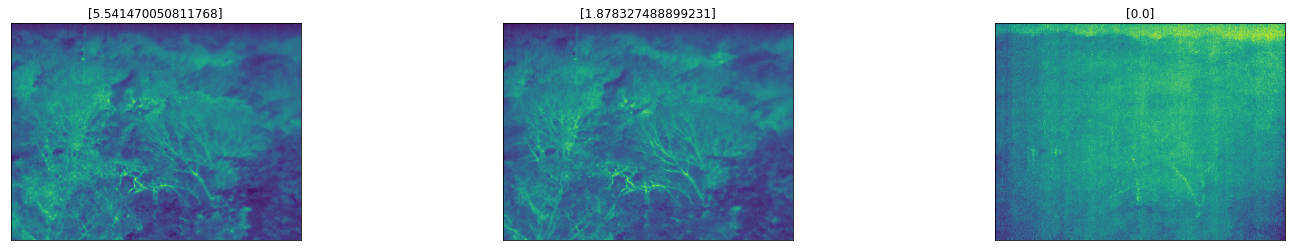

In [55]:
""" VISUALIZE A BATCH OF THE DATA 
    Taken straight from dataloader """
os.chdir(startingDir)
#csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000"
os.chdir(csvfilesMLLocation)

import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.imshow(np.rot90(np.squeeze(img)))
    
# Obtain one batch of training images
dataiter = iter(train_loader)
type(dataiter)
images, labels = dataiter.next()
print(images.shape)
images = images.numpy() # convert images to numpy for display
#print(images)

    # print(images[1].shape)
    # imgtoshow = Image.fromarray(images[1], 'L')
    # imgtoshow.show()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 3 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    print(labels[idx])
    print(labels[idx].long())
    ax.set_title([labels[idx].item()])
    # Save Images for inspection
    print(images[idx].shape)
os.chdir(startingDir)

In [28]:
"""Working network"""
class BCIModel(nn.Module):
    def __init__(self):
        super(BCIModel, self).__init__()
        # Convulutional Layer 1 (sees 320 x 240 x 1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        # Convulutional Layer 2 (sees 160 x 120 x 16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # Convulutional Layer 3 (sees 80 x 60 x 32 tensor, reduced height and width from max pooling layer and stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # Convulutional Layer 4 (sees 40 x 30 x 64 tensor, reduced height and width from max pooling layer and stride=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Linear and Batchnorm Layers
        self.fc1 = nn.Linear(128 * 20 * 15, 100)
        self.BatchN = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 1)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Add sequence of convulutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 20 * 15)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add last layer
        x = (self.fc2(x))
        return x

In [39]:
#n_epochs = 50
#raise Exception("Not currently creating new model")
# Defining the model
model = BCIModel()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr =0.01)
# defining the scheduler, to handle learning rate changes
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.97)

# lmbda = lambda epoch: 1.22 #float(epoch) / 20.0
# scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
# rater = 0.001
# for epoch in range(1,n_epochs):
#     print("Epoch Number", epoch, "has LR:", rater * lmbda(epoch))
#     rater = rater * lmbda(epoch)
    
# defining loss function
criterion = nn.MSELoss()
print(model)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=38400, out_features=100, bias=True)
  (BatchN): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...


In [40]:
torch.cuda.empty_cache() 

In [41]:
# Optimization? Best for inputs that do not change in size (this network)
# "This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware"
torch.backends.cudnn.benchmark = True

# Check that we are on GPU
for p in model.parameters():
    print(p.device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [10]:
""" IMPORT MODEL FOR RETRAIN """
os.chdir(csvfilesMLLocation)
importFlag = input("Are you sure you want to overwrite this model? ")
if importFlag != "Yes":
    raise exception

# Print out values and images that have large differences in target/value
importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Good_Models/model_BCI_10000_6_17.pt"

# Track test loss

num_predictions = len(test_indices)

# Import model
valid_loss_min = 0.9433
model.load_state_dict(torch.load(importModelPath))

Are you sure you want to overwrite this model? Yes


<All keys matched successfully>

In [56]:
#optimizer.param_groups[0]['lr'] = 0.1

In [46]:
""" TRAINING OF MODEL """



# CHECK VALID AND TRAIN LOSS FOR VALID VAS
# current saved model from runs as seen



os.chdir(startingDir)
#csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000"
os.chdir(csvfilesMLLocation)
# Number of epochs to train the model
# try 10, 100, 500, 1000
n_epochs = 15
test_loss = 0.0
#valid_loss_min = np.Inf    # Track change in validation loss, set


train_loss_vals = []
valid_loss_vals = []
epochCounter = []
lr_vals = []

for epoch in range(1, n_epochs+1):
    epochCounter.append(epoch)
    lr_vals.append(optimizer.param_groups[0]['lr'])    
    # Measurement of epoch times
    start = time.time()
    print("Epoch #:", epoch)
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # Clear the gradients fo all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()
        
    
    # Calculate avearage losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    # Update validation loss list
    valid_loss_vals.append(valid_loss)
    # Update training loss list
    train_loss_vals.append(train_loss)
    
    # Print training/validation stats
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_BCI.pt')
        valid_loss_min = valid_loss
    
    # End of time check
    print(f'Time: {time.time()-start}')
    print("LR:",optimizer.param_groups[0]['lr'])
#     scheduler.step()
#     print("After LR:",optimizer.param_groups[0]['lr'])

    # Step the lr_scheudler 
    if epoch >= 33:
        scheduler.step()
#     if epoch % 4 == 0:
#         if optimizer.param_groups[0]['lr'] == 0.10:
#             optimizer.param_groups[0]['lr'] = 0.01
#         if optimizer.param_groups[0]['lr'] == 0.01:
#             optimizer.param_groups[0]['lr'] = 0.10
        
print("Operation Complete")

# Epochs for 10,000 files take 280 s per epoch
# Epochs for 4,000 files take 101 s per epoch
# Epochs for 2,500 files take 65 s per epoch
# Epochs for 933 files take 24 s per epoch

Epoch #: 1
Epoch: 1 	Training Loss: 1.278686 	Validation Loss: 1.275906
Validation loss decreased (12.592356 --> 1.275906).  Saving model ...
Time: 334.5129337310791
LR: 0.00912673
Epoch #: 2
Epoch: 2 	Training Loss: 1.277148 	Validation Loss: 1.276371
Time: 331.70933532714844
LR: 0.00912673
Epoch #: 3
Epoch: 3 	Training Loss: 1.278213 	Validation Loss: 1.274734
Validation loss decreased (1.275906 --> 1.274734).  Saving model ...
Time: 333.4110314846039
LR: 0.00912673
Epoch #: 4
Epoch: 4 	Training Loss: 1.272941 	Validation Loss: 1.275420
Time: 331.78168988227844
LR: 0.00912673
Epoch #: 5
Epoch: 5 	Training Loss: 1.277289 	Validation Loss: 1.278283
Time: 333.3310523033142
LR: 0.00912673
Epoch #: 6
Epoch: 6 	Training Loss: 1.274227 	Validation Loss: 1.277931
Time: 332.5019884109497
LR: 0.00912673
Epoch #: 7
Epoch: 7 	Training Loss: 1.272614 	Validation Loss: 1.274140
Validation loss decreased (1.274734 --> 1.274140).  Saving model ...
Time: 333.97899651527405
LR: 0.00912673
Epoch #: 8
E

In [34]:
""" EPOCH TIME CALC """
fileSize = 10000.0
minutesToTrain = 60.0 * 9

secondsPerEpoch = (0.0287*(fileSize) - 6.4268)
secondsToTrain = minutesToTrain * 60.0
epochsToUse = secondsToTrain/secondsPerEpoch
print("To train for", minutesToTrain, "minutes use", epochsToUse, "epochs") 

To train for 540.0 minutes use 115.4778859848339 epochs


In [38]:
temp_train_loss_vals = train_loss_vals
temp_valid_loss_vals = valid_loss_vals
temp_epochCounter = epochCounter
temp_lr_vals = lr_vals
print(train_loss_vals)
print(valid_loss_vals)
print(epochCounter)
print(lr_vals)

[0.1197803649553068, 0.12368696893856024, 0.12263634888229856, 0.11635553145864207, 0.12001484721709209, 0.12357914766688256, 0.12395201245690607, 0.11773645171693936, 0.1148176739929588, 0.11532238323217744]
[0.15458721533572692, 0.15656202473576675, 0.15854278237823213, 0.15330942955980684, 0.15743241976132896, 0.1589311735059673, 0.15306200244274396, 0.1578835020447911, 0.1534643045683318, 0.14835668106135783]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2\csvdata10000


<Figure size 1080x72 with 0 Axes>

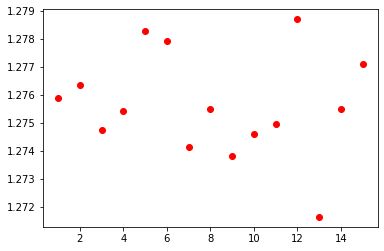

<Figure size 1080x72 with 0 Axes>

In [47]:
""" CREATION OF TEST RANGE LR PLOT """
print(os.getcwd())
plt.scatter(epochCounter, valid_loss_vals, c="red")
#plt.xlim(0,0.05)
# plt.ylim(0,100)
plt.figure(figsize=(15,1))


In [1]:
""" CREATION OF GENERALIZATION PLOT """
# genPlotFig =plt.figure()
# genPlotFig.add_axes([0,0,1,1])
# ax.scatter(epochCounter, train_loss_vals, color='r')
# ax.scatter(epochCounter, valid_loss_vals, color='b')

# ax.set_title('Genralization Plot')
colors = ("red", "green")
groups = ("training", "validation")
data = ((epochCounter, train_loss_vals), (epochCounter, valid_loss_vals))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    plt.plot(x,y,'-o',c=color)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
y = np.array([2,4,6,8,10,12,14,16,18])
plt.xticks(np.arange(0, n_epochs+2, step=2))

plt.title("Generalization Plot")
plt.legend()
plt.show()

NameError: name 'epochCounter' is not defined

In [45]:
torch.set_printoptions(precision=4, sci_mode=False)

In [49]:
""" TESTING OF MODEL """

# Print out values and images that have large differences in target/value

# Track test loss
test_loss = 0.0
num_predictions = len(test_indices)

# Puts model will notify all your layers that you are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.
model.eval()

start = time.time()
counter = 0
# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update test loss 
        test_loss += loss.item()
        
        # Example data tensors
        if counter < 2:
            print("loss from this run:", loss.item())
            #print("Output of network:\t", output)
            counterTHIS = 0
            for value in output:
                counterTHIS += 1
                if value.item() > 2.0:
                    print("Output", counterTHIS, ":", value.item())
            counterTHIS = 0
            for value in target:
                counterTHIS += 1
                if value.item() > 2.0:
                    print("Target", counterTHIS, ":", value.item())
            #print("Target Values:\t", target,"\n")
            counter += 1
            # CHECK LOss HEEWRE
        


    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))
print(f'Time: {time.time()-start}')

loss from this run: 72.43155670166016
Output 1 : 7.51934289932251
Output 2 : 7.51934289932251
Output 3 : 7.51934289932251
Output 4 : 7.51934289932251
Output 5 : 7.51934289932251
Output 6 : 7.51934289932251
Output 7 : 7.51934289932251
Output 8 : 7.51934289932251
Output 9 : 7.51934289932251
Output 10 : 7.51934289932251
Output 11 : 7.51934289932251
Output 12 : 7.51934289932251
Output 13 : 7.51934289932251
Output 14 : 7.51934289932251
Output 15 : 7.51934289932251
Output 16 : 7.51934289932251
Output 17 : 7.51934289932251
Output 18 : 7.51934289932251
Output 19 : 7.51934289932251
Output 20 : 7.51934289932251
Output 21 : 7.51934289932251
Output 22 : 7.51934289932251
Output 23 : 7.51934289932251
Output 24 : 7.51934289932251
Output 25 : 7.51934289932251
Output 26 : 7.51934289932251
Output 27 : 7.51934289932251
Output 28 : 7.51934289932251
Output 29 : 7.51934289932251
Output 30 : 7.51934289932251
Output 31 : 7.51934289932251
Output 32 : 7.51934289932251
Output 33 : 7.51934289932251
Output 34 : 7.

In [57]:
""" TESTING OF IMPORTED MODEL """
os.chdir(csvfilesMLLocation)

# Print out values and images that have large differences in target/value
#mportModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata9000/model_BCI.pt"
importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Good_Models/model_BCI_old_method_4000.pt"
# Track test loss
test_loss = 0.0
num_predictions = len(test_indices)

# Import model
model2 = BCIModel()
model2.cuda()
model2.load_state_dict(torch.load(importModelPath))

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model2.cuda()

# Puts model will notify all your layers that you are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.
model2.eval()

max_loss = -10.0
targetList = [-10.0,-10.0,-10.0]
outputList = [-10.0,-10.0,-10.0]

thresh_max = 13
max_count = 0
not_included_count = 0

start = time.time()
counter = 0
predictions_divide_three = 0
test_loss_real = 0
# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        predictions_divide_three += 1
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        
        if(loss.item() > thresh_max):
            max_count += 1
        
        if(loss.item() > max_loss):
            max_loss = loss.item()
            for num in range(batch_size):
                targetList[num] = target[num].item()
                outputList[num] = output[num].item()
        
        
        test_loss_real += loss.item()
        # Update test loss
        if(loss.item() < thresh_max):
            test_loss += loss.item()
        else:
            not_included_count += 1
        
        #print(type(target[0].item()))
        
        #raise Exception("DO NOT TRAIN, EVALUATION ONLY")
        
        # Example data tensors
        if counter < 10:
            print("test loss from", counter, ":", loss.item())
            print("Output of network:\t", output)
            print("Target Values:\t\t", target,"\n")
            counter += 1
        
    test_loss = test_loss/((predictions_divide_three-not_included_count)*3)
    test_loss_real = test_loss_real/(predictions_divide_three*3)
    print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))
    print('Test Loss Real (mean squared error): {:.6f}\n'.format(test_loss_real))
print(f'Time: {time.time()-start}')

print("Max loss:", max_loss)
print("targets:", targetList)
print("output:", outputList)
print("max_count:", max_count)



#look at difference between with and without bigerros

CUDA is available!  Training on GPU ...
test loss from 0 : 3.7797021865844727
Output of network:	 tensor([20.5998, 16.3806, 12.7713], device='cuda:0')
Target Values:		 tensor([20.8489, 15.1336,  9.6533], device='cuda:0') 

test loss from 1 : 4.38726806640625
Output of network:	 tensor([ 0.1260,  1.7152, 18.9610], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000, 22.1554], device='cuda:0') 

test loss from 2 : 2.5896718502044678
Output of network:	 tensor([2.7682, 0.3165, 0.0753], device='cuda:0')
Target Values:		 tensor([0., 0., 0.], device='cuda:0') 

test loss from 3 : 5.443870544433594
Output of network:	 tensor([ 6.3443, 19.2621, 12.9869], device='cuda:0')
Target Values:		 tensor([ 2.6200, 17.7380, 13.3591], device='cuda:0') 

test loss from 4 : 31.555572509765625
Output of network:	 tensor([18.4008,  8.2779, 14.8192], device='cuda:0')
Target Values:		 tensor([18.1130, 12.8780, 23.3879], device='cuda:0') 

test loss from 5 : 1.1772778034210205
Output of network:	 tensor([

In [18]:
print(num_predictions)

375
